In [1]:
import numpy as np
import os,sys
import matplotlib.pyplot as plt
from xfoil import XFoil
from xfoil.model import Airfoil as XFAirfoil
from xfoil.test import naca0012

from pathlib import Path
from airLibs import airfoil as af
from airLibs import runF2w as f2w
from airLibs import plotting as aplt
from airLibs import runOpenFoam as of

from subprocess import call

# Reynolds And Mach and AoA

In [2]:
def ms2mach(ms):
    return ms/340.29
def Re(v,c,n):
    return (v*c)/n

In [3]:
chordMax = 0.18
chordMin = 0.11
umax = 30
umin = 5
ne = 1.56e-5

In [4]:
Machmin = ms2mach(10)
Machmax = ms2mach(30)
Remax = Re(umax,chordMax,ne)
Remin = Re(umin,chordMin,ne)
AoAmax = 15
AoAmin = -6
NoAoA = (AoAmax - AoAmin)*2 + 1

In [5]:
angles = np.linspace(AoAmin,AoAmax,NoAoA)
Reynolds = np.logspace(np.log10(Remin),np.log10(Remax),20,base=10)
Mach = np.linspace(Machmax,Machmin,10)

In [6]:
CASE = 'Wing'
os.chdir(CASE)
casedir = os.getcwd()
plotting = True
cleaning = False
calcF2W = False
calcOpenFoam = False
calcXFoil= False

# Get Airfoil

In [7]:
for i in os.listdir():
    if i.startswith('naca'):
        airfile = i
airfoil = airfile[4:]

# Generate Airfoil

(-0.05, 1.05, -0.049705262133265996, 0.12146125008203564)

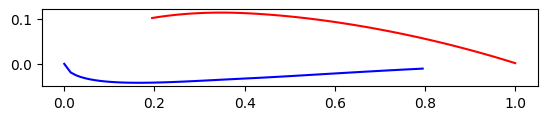

In [8]:
n_points = 100
pts = af.saveAirfoil(['s',airfile,airfoil,0,n_points])
x,y = pts.T
plt.plot(x[:n_points-20],y[:n_points-20],'r')
plt.plot(x[n_points:-20],y[n_points:-20],'b')

# plt.plot(x,y)
plt.axis("scaled")

# Setup Case

In [9]:
Ncrit = 9
ftrip_low = {'pos':0.1,'neg':0.2} 
ftrip_up  = {'pos':0.1,'neg':0.2} 

angles = np.linspace(-6,15,43)
Reyn = 346153 #np.logspace(3,6,20)
MACH = 0.03

# Foil2Wake

In [10]:
if cleaning == True:
    f2w.deleteResults()
if calcF2W == True:
    clcd = f2w.runFw2(Reyn,MACH,ftrip_low,ftrip_up,angles,airfile)
clcdcmFW = f2w.makeCLCD(Reyn,MACH,angles)

OK


# Xfoil

In [11]:
xf = XFoil()
xf.Re = Reyn
xf.max_iter = 40
xf.print = False
xpts,ypts = pts.T
naca0008 = XFAirfoil(x=xpts,y=ypts)
xf.airfoil = naca0008
aXF, clXF, cdXF, cmXF,cpXF = xf.aseq(-6, 15, 0.5)
clcdcmXF = np.array([aXF, clXF, cdXF, cmXF]).T

# OpenFoam

In [12]:
os.chdir(casedir)
if calcOpenFoam == True:
    of.makeMesh(airfile)
    of.setupOpenFoam(Reyn,MACH,angles[-11:],silent = True)
    of.runFoam(angles[-11:])
clcdcmOF = of.makeCLCD(angles)

# Plotting

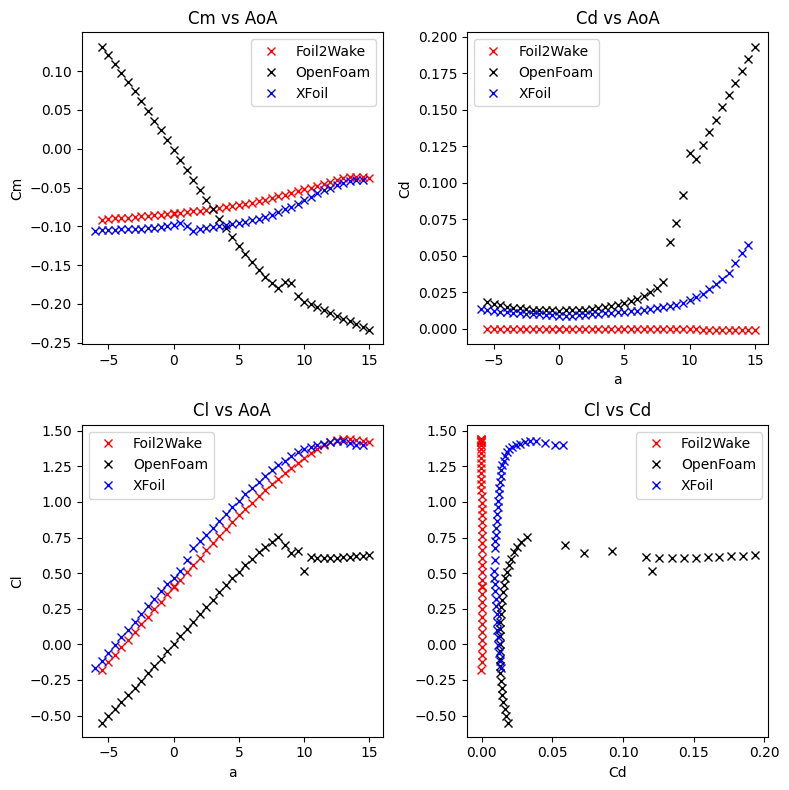

In [13]:
f2w = [clcdcmFW,'rx','Foil2Wake']
openF = [clcdcmOF,'kx','OpenFoam']
Xfoil = [clcdcmXF,'bx','XFoil']
aplt.plotAeorCoeffs([f2w,openF,Xfoil])